In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('/Users/hansonzhao/Downloads/reddit_data.csv')
df.head()


,timestamp,subreddit,selftext,is_gallery,title,thumbnail_height,upvote_ratio,ups,thumbnail_width,score,...,id,author,num_comments,stickied,url,subreddit_subscribers,created_utc,num_crossposts,is_video,post_hint
0,1.740031e+09,news,NaN,NaN,"Trump can’t end birthright citizenship, appeal...",78.0,0.98,17843,140.0,17843,...,1itoi1k,MalcolmLinair,957,False,https://www.cnn.com/2025/02/19/politics/trump-...,29514062,1.740021e+09,1,False,link
1,1.740031e+09,AskReddit,NaN,NaN,What will Americans do if Social Security is r...,NaN,0.86,16500,NaN,16500,...,1it86ez,TheScrutinist,15226,False,https://www.reddit.com/r/AskReddit/comments/1i...,51734018,1.739979e+09,4,False,NaN
2,1.740031e+09,pics,NaN,NaN,Ukraine President Zelensky handes over a battl...,93.0,0.93,28025,140.0,28025,...,1itngdc,XaltotunTheUndead,1014,False,https://i.redd.it/at7o2pq6d7ke1.jpeg,31399815,1.740017e+09,6,False,image
3,1.740031e+09,Conservative,NaN,NaN,Trump finally calls out the Ukraine scam,140.0,0.76,8079,140.0,8079,...,1it94t4,theboss2461,9337,False,https://i.redd.it/a5qig6r2e4ke1.png,1204356,1.739981e+09,11,False,image
4,1.740031e+09,MadeMeSmile,NaN,NaN,Good Husband,140.0,0.92,49342,140.0,49342,...,1itmjwe,annadarria,624,False,https://v.redd.it/r0h9j4f457ke1,11111113,1.740015e+09,6,True,hosted:video


In [3]:
#Data Cleaning

#Clean Duplicate
df.drop_duplicates(subset='id', inplace=True)
#Hot Encoding, turn TRUE and FALSE into 1 and 0
cols_to_convert = ['allow_live_comments', 'media_only', 'spoiler', 'stickied', 'is_video']
for col in cols_to_convert:
    df[col] = df[col].apply(lambda x: int(x) if isinstance(x, bool) else x)
df.head()
#Convert UTC to DD-MM-YYYY
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['created_utc'] = df['created_utc'].dt.strftime('%d-%m-%Y')

In [4]:
titles = []
for title in df['title']:
    if title not in titles:
        titles.append(title)
print(titles)

['Trump can’t end birthright citizenship, appeals court says, setting up Supreme Court showdown', 'What will Americans do if Social Security is reduced or done away with?', 'Ukraine President Zelensky handes over a battle flag to representatives of US Congress. Dec. 2022', 'Trump finally calls out the Ukraine scam', 'Good Husband', 'Detroit was flooded and it froze over night. Cars are stuck.', 'Trump attacks Zelensky in a post, calls him a dictator', 'Trump launches fresh attack on Zelensky, calling him a “dictator”', 'Ukrainians, Stunned by Trump’s Comments, Fear They Can No Longer Trust U.S.', 'Just saying', 'Poor Joe Rogan', 'meirl', "AITAH if I'm upset that my husband mentioned getting a paternity test?", 'Former Vikings punter Chris Kluwe calling President Donald Trumps MAGA slogan a "Nazi movement" and being arrested and carried out of a city council meeting by police', 'Fuck the king', '🔥robot bug on the right meets real bug', 'POTUS just seized absolute Executive Power. A very

In [13]:
#Cluster the Subreddits using K-means Cluster
import transformers
from transformers import pipeline
import torch

#Categorize the subreddits
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Get embeddings
embeddings = model.encode(titles, convert_to_tensor=True)
embeddings_cpu = torch.tensor(embeddings).cpu().numpy() # you could pass in your own sentences instead of the given ones
print(embeddings.shape)  # (num_texts, embedding_dim)

torch.Size([8997, 384])


/var/folders/s4/2rhd86tn2zj814lw9r5mmc0m0000gn/T/ipykernel_6653/1102360501.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_cpu = torch.tensor(embeddings).cpu().numpy() # you could pass in your own sentences instead of the given ones


In [14]:
from sklearn.cluster import KMeans

# Fit KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=0) # 8 clusters for the 8 topics of the generated sentences
clusters = kmeans.fit_predict(embeddings_cpu) # pass in the embeddings here

# Get cluster labels for each sentence
labels = kmeans.labels_
labels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


array([6, 6, 6, ..., 6, 2, 6], shape=(8997,), dtype=int32)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Convert texts into TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(titles)
terms = np.array(vectorizer.get_feature_names_out())

# Get top words per cluster
for cluster_id in set(labels):
    cluster_indices = [i for i, c in enumerate(labels) if c == cluster_id]
    cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0).A1
    top_terms = terms[np.argsort(-cluster_tfidf)[:3]]
    print(f"Cluster {cluster_id}: {', '.join(top_terms)}")

Cluster 0: girl, woman, love
Cluster 1: game, art, like
Cluster 2: cat, dog, got
Cluster 3: just, don, like
Cluster 4: bowl, super, kendrick
Cluster 5: new, just, years
Cluster 6: trump, musk, elon
Cluster 7: irlgbt, ich, iel


In [16]:
#Get the name of each subreddits
subreddits = []
for subreddit in df['subreddit']:
    if subreddit not in subreddits:
        subreddits.append(subreddit)
print(subreddits)

['news', 'AskReddit', 'pics', 'Conservative', 'MadeMeSmile', 'mildlyinfuriating', 'worldnews', 'europe', 'BlueskySocial', 'rareinsults', 'meirl', 'AITAH', 'Global_News_Hub', 'gameofthrones', 'NatureIsFuckingLit', 'Futurology', 'popculturechat', 'law', 'antiwork', 'GenZ', 'interestingasfuck', 'okbuddycinephile', 'ExplainTheJoke', 'Ohio', 'nottheonion', 'aww', 'technology', 'nba', 'mildlyinteresting', 'illinois', 'NBATalk', 'Baking', 'SubredditDrama', 'Eyebleach', 'politics', 'moviecritic', 'lazerpig', 'BeAmazed', 'agedlikemilk', 'PeterExplainsTheJoke', 'JonStewart', 'Music', 'Advice', 'MurderedByWords', 'nextfuckinglevel', 'popculture', 'oddlysatisfying', 'geography', 'CuratedTumblr', 'marvelrivals', 'WorkReform', 'instant_regret', 'NoStupidQuestions', 'BlackPeopleTwitter', 'clevercomebacks', 'gaming', 'fednews', 'AmIOverreacting', 'todayilearned', 'comics', 'TheDepthsBelow', 'SquaredCircle', 'cyberpunkgame', 'OldSchoolCool', 'MildlyBadDrivers', 'TikTokCringe', 'UkraineWarVideoReport', 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


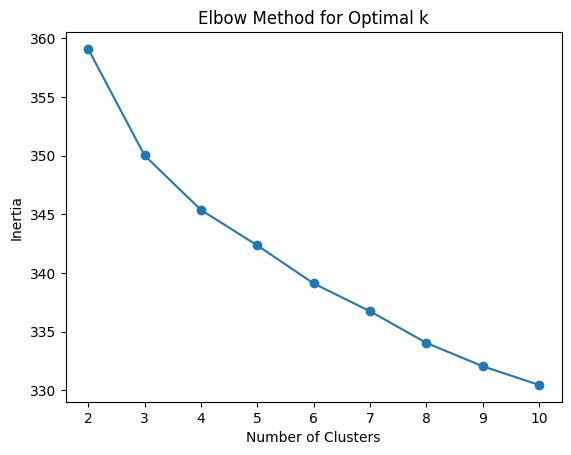

Cluster 0: warthundermemes, deathstranding, botecodoreddit
Cluster 1: satisfyingasfuck, thelib, brawlstars
Cluster 2: edgerunners, steelers, coolguides
Cluster 3: luftablassen, davidlynch, sifugame
Cluster 4: righteousgemstones, badassanimals, impracticaljokers
Cluster 5: leagueofmemes, humanbeingbros, thisyoucomebacks
Cluster 6: 1102, eragon, scams
Cluster 7: the_everything_bubble, carscirclejerk, canceledpod
Cluster 8: zzz_official, plussizefashion, discoelysium
Cluster 9: nova, work, delta

Cluster: nova, work, delta
news, law, news, technology, politics, politics, law, Music, gaming, technology, cats, politics, law, politics, technology, Music, cats, interesting, Music, science, sports, gaming, news, videos, news, cats, law, law, politics, technology, wow, de, cats, de, technology, politics, cats, Steam, sports, technology, politics, Music, Music, travel, news, politics, law, cats, cats, cats, politics, gaming, Music, politics, technology, cats, gaming, science, Steam, wow, technol

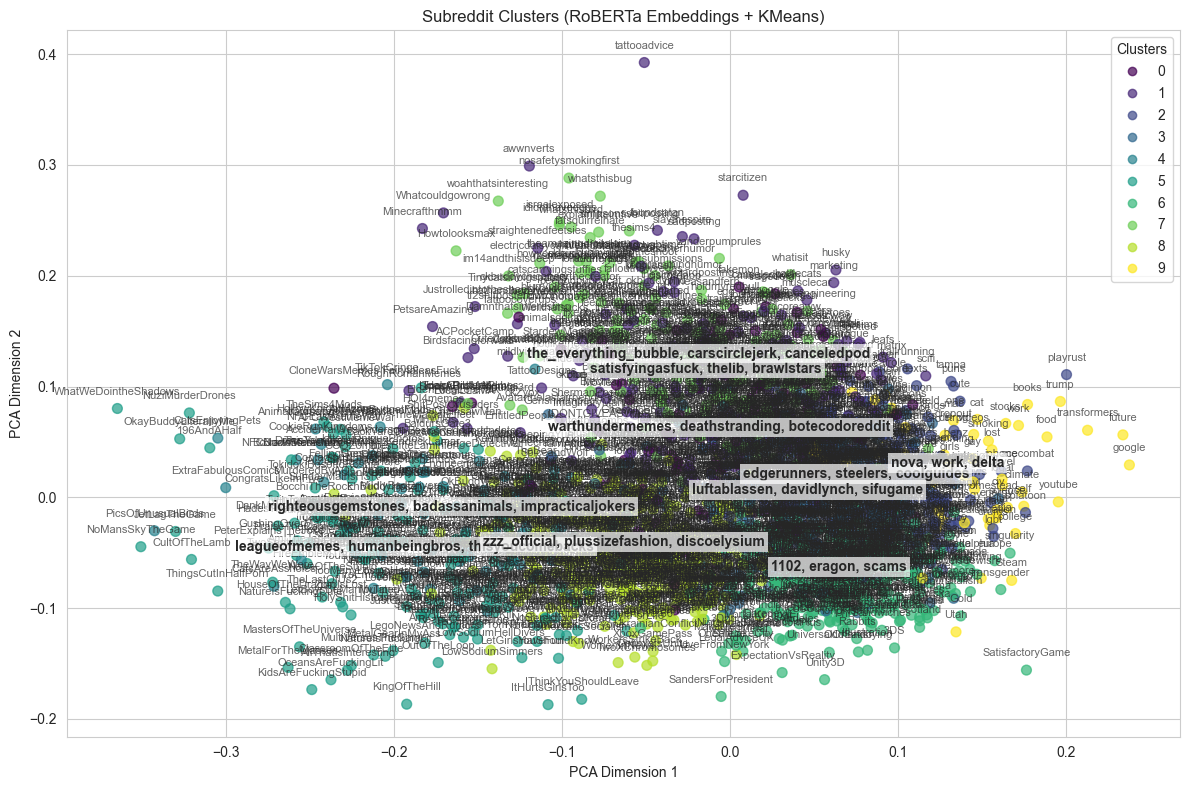

In [22]:
#Use Roberta model to cluster
from transformers import RobertaTokenizer, RobertaModel
import torch
from sklearn.decomposition import PCA

# Load RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Tokenize subreddits and get embeddings
inputs = tokenizer(subreddits, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # CLS embeddings

# Determine optimal number of clusters using elbow method (optional but recommended)
inertia = []
for n_clusters in range(2, 11):  # Test a range of cluster numbers
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init = 'auto')
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose optimal k based on the elbow plot (e.g., k=5 in this example)
n_clusters = 10  # Replace with the optimal k value

# Cluster
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init = 'auto')
clusters = kmeans.fit_predict(embeddings)
labels = kmeans.labels_


# Create cluster labels (more descriptive than just numbers)
cluster_topics = {}
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(subreddits)
terms = np.array(vectorizer.get_feature_names_out())

for cluster_id in range(n_clusters):
    cluster_indices = [i for i, c in enumerate(labels) if c == cluster_id]
    cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0).A1
    top_terms = terms[np.argsort(-cluster_tfidf)[:3]]  # Get top 3 terms
    cluster_topics[cluster_id] = ", ".join(top_terms)
    print(f"Cluster {cluster_id}: {', '.join(top_terms)}")

# Assign cluster labels to subreddits
df['cluster_label'] = df['subreddit'].apply(lambda x: labels[subreddits.index(x)])
df['cluster_name'] = df['cluster_label'].apply(lambda x: cluster_topics[x]) # Add descriptive name

# 1. Separate clusters by labels (using the dataframe)
for cluster_name in df['cluster_name'].unique():
    print(f"\nCluster: {cluster_name}")
    print(", ".join(df[df['cluster_name'] == cluster_name]['subreddit'].tolist()))




# 2. Graph the cluster map with labels (improved visualization)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 8))  # Larger figure for better readability
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("hls", n_clusters))  # Distinct colors

# Scatter plot with cluster labels as annotations
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7, s=50)  # Increased marker size

for i, subreddit in enumerate(subreddits):
    x, y = reduced_embeddings[i]
    cluster_label = labels[i]
    plt.annotate(subreddit, (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, alpha=0.7) # Subreddit names as annotations

# Add cluster center annotations (optional)
cluster_centers = []
for cluster_id in range(n_clusters):
    cluster_centers.append(reduced_embeddings[labels == cluster_id].mean(axis=0))

for i, center in enumerate(cluster_centers):
    x, y = center
    plt.annotate(cluster_topics[i], (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)) # Box around cluster names


plt.title('Subreddit Clusters (RoBERTa Embeddings + KMeans)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
